# Step 1 – Loading the data and getting acquainted

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX # ARIMAX MODEL
from scipy.signal import find_peaks
from sklearn.preprocessing import LabelEncoder



* pandas – table and time management

* numpy – numerical calculations

* matplotlib / seaborn – graphs

* sklearn.metrics – model quality metrics

* SARIMAX – implementation of ARIMA with external variables

In [2]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

## Visualization settings
Design only – no impact on the model at all

## Loads the Excel file into a data frame.
Downloads data directly from Google Sheets
* The dataset is already shared to everyone so its should work


In [3]:
link_data_set = "https://docs.google.com/spreadsheets/d/11Rxanudelds7-YqOzUx1VOZpGadoxAxt/edit?usp=sharing&ouid=102402738579845008962&rtpof=true&sd=true"

file_id ="11Rxanudelds7-YqOzUx1VOZpGadoxAxt"

url = f"https://docs.google.com/spreadsheets/d/{file_id}/export?format=xlsx"

file_path = "Adidas.xlsx"


df = pd.read_excel(url)

In [4]:
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.50,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.30,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40.0,1000,400000.0,140000.0,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,45.0,850,382500.0,133875.0,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60.0,900,540000.0,162000.0,0.30,In-store


# Step 2 – Preparing the data for a time series

## 2.1 Converting a date to a time format
The model needs to know that this is real time, not text.

In [5]:
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

A time series must be arranged chronologically

In [6]:
df = df.sort_values('Invoice Date')

# 2.2 Daily aggregation

In [7]:
# Aggregate transaction-level data to daily frequency for time series analysis
daily_df = df.groupby('Invoice Date').agg({
    'Units Sold': 'sum',
    'Price per Unit': 'mean',
})

Moving from transaction level → daily level:

* We have combined daily sales

* Price → Daily average

* Profit and revenue → Daily amount

In [8]:
daily_df.head()

,Units Sold,Price per Unit
Invoice Date,,
2020-01-01,2361,54.500000
2020-01-02,2310,37.833333
2020-01-03,2302,38.666667
2020-01-04,2085,40.666667
2020-01-05,1917,46.666667


# Step 3 – Visualization

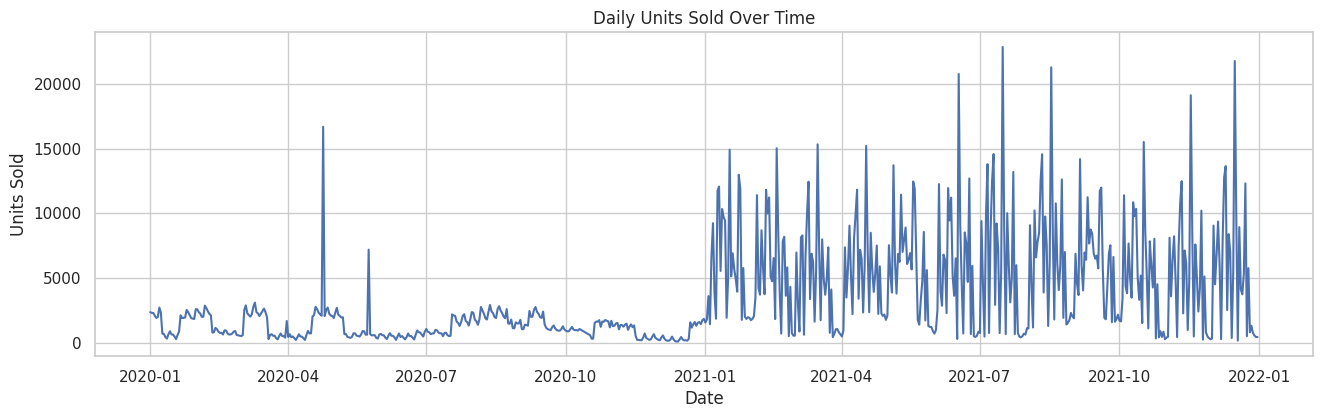

In [9]:
plt.figure(figsize=(14,4))
plt.plot(daily_df.index, daily_df['Units Sold'])
plt.title("Daily Units Sold Over Time")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

In [10]:
df_2021 = daily_df.loc['2021-01-01':'2021-12-31']

In [11]:
# To generate this table, we computed the summary statistics (Mean, Standard Deviation, Min, and Max) for the key numerical features Units Sold, Price per Unit, and Operating Profit using the 2021 dataset.
cols_for_stats = ['Units Sold', 'Price per Unit']

desc_stats = df_2021[cols_for_stats].describe().T[['mean', 'std', 'min', 'max']]

pd.options.display.float_format = '{:,.2f}'.format

print("\n--- Table 2: Descriptive Statistics ---")
print(desc_stats)

desc_stats.to_csv('descriptive_statistics.csv')
print("\nTable saved to 'descriptive_statistics.csv'")


--- Table 2: Descriptive Statistics ---
                   mean      std    min       max
Units Sold     5,524.69 4,276.55 163.00 22,857.00
Price per Unit    43.79     9.23  17.33     76.92

Table saved to 'descriptive_statistics.csv'


## Filter data to include only post-COVID period to ensure consistent market behavior

30-Day Rolling Mean

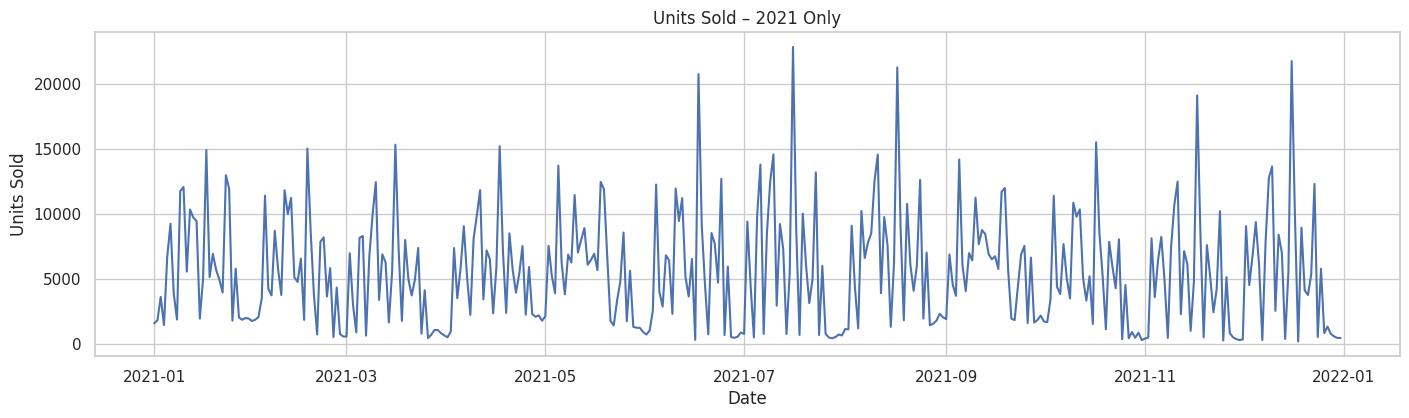

In [12]:
plt.figure(figsize=(15,4))
plt.plot(df_2021.index, df_2021['Units Sold'])
plt.title("Units Sold – 2021 Only")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

In [13]:
df_2021_copy = df_2021.copy()

# Comparison by day of the week (for understanding purposes only!)

In [14]:
df_2021_copy['day_of_week'] = df_2021_copy.index.day_name()

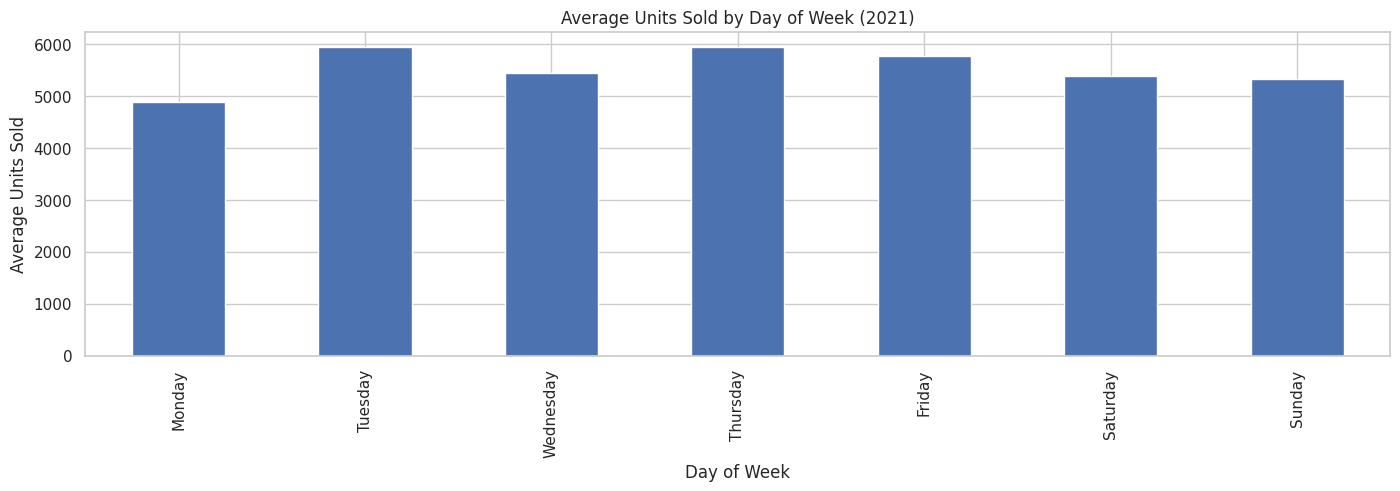

In [15]:
dow_avg = df_2021_copy.groupby('day_of_week')['Units Sold'].mean()
dow_avg = dow_avg.reindex([
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(15,4))
dow_avg.plot(kind='bar')
plt.title("Average Units Sold by Day of Week (2021)")
plt.xlabel("Day of Week")
plt.ylabel("Average Units Sold")
plt.show()

## I don't see too much difference between the days of the week.

# Comparison by day of the month

In [16]:
df_2021_copy['day_of_month'] = df_2021.index.day

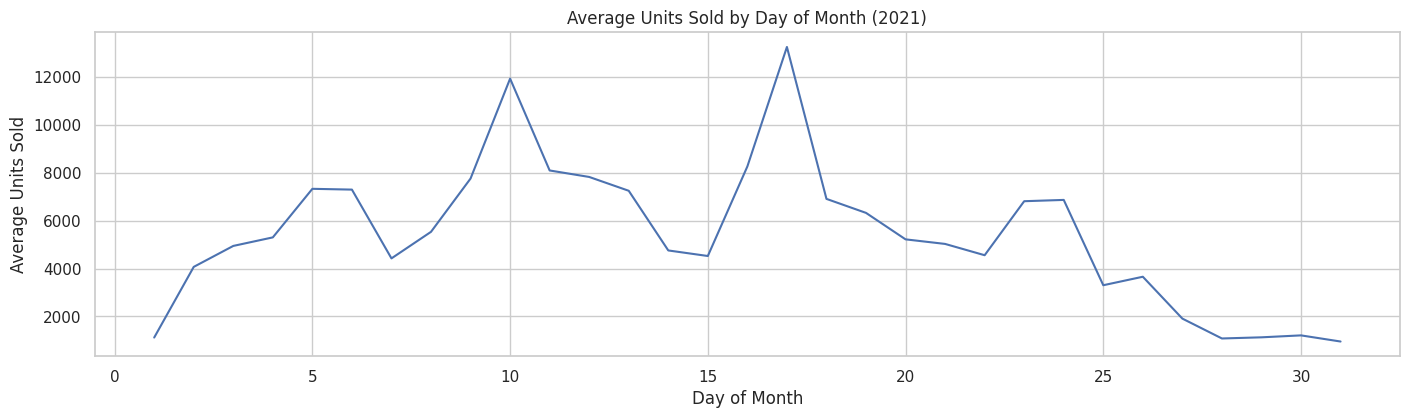

In [17]:
dom_avg = df_2021_copy.groupby('day_of_month')['Units Sold'].mean()

plt.figure(figsize=(15,4))
plt.plot(dom_avg.index, dom_avg.values)
plt.title("Average Units Sold by Day of Month (2021)")
plt.xlabel("Day of Month")
plt.ylabel("Average Units Sold")
plt.show()

# Daily Observed Sales

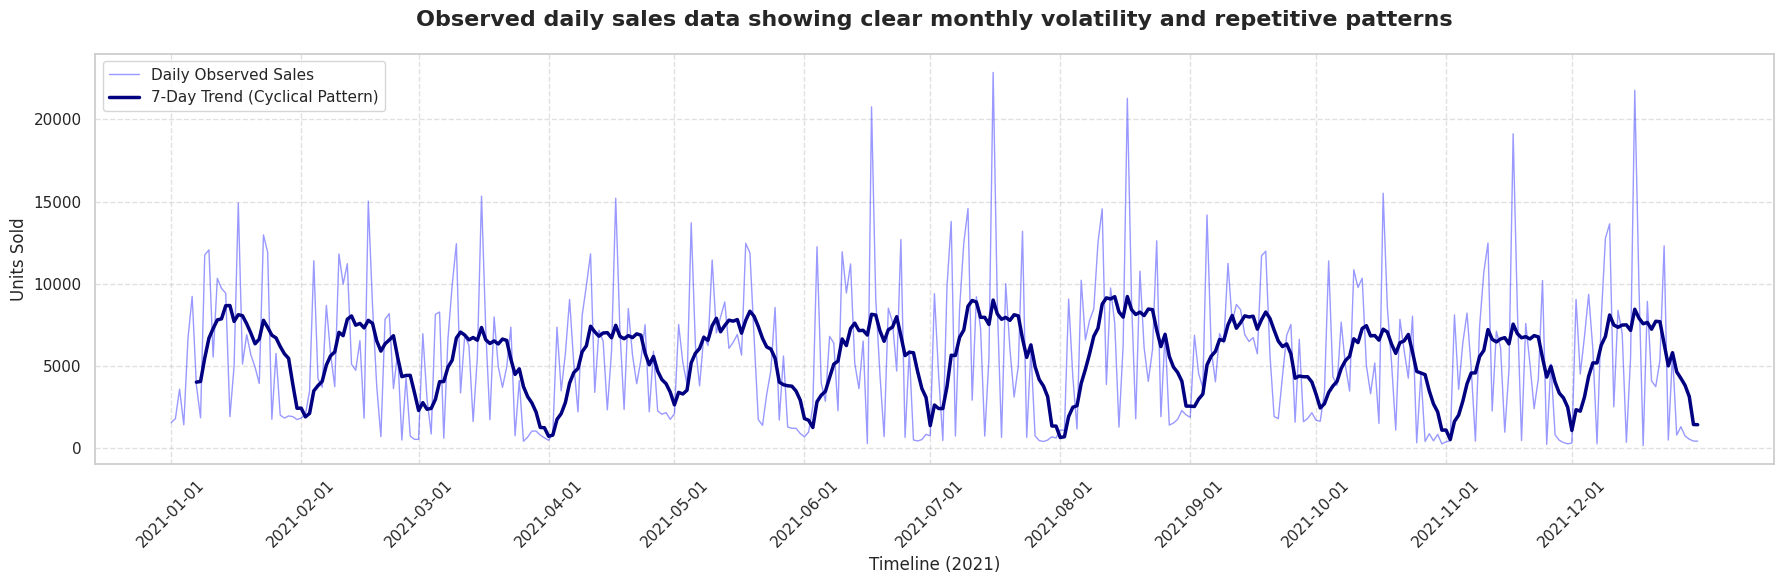

In [18]:
# Observed daily sales data analysis

plt.figure(figsize=(18, 6))

# Plotting the raw daily data (The "Volatility")
# We use a thinner line and some transparency to show the raw spikes
plt.plot(df_2021_copy.index, df_2021_copy['Units Sold'],
         color='blue', alpha=0.4, linewidth=1, label='Daily Observed Sales')

# Plotting a 7-day Moving Average (The "Wave Pattern")
# This helps visualize the cyclical behavior mentioned in your text
plt.plot(df_2021_copy.index, df_2021_copy['Units Sold'].rolling(window=7).mean(),
         color='navy', linewidth=2.5, label='7-Day Trend (Cyclical Pattern)')

# Formatting the Graph to match professional reporting

plt.title('Observed daily sales data showing clear monthly volatility and repetitive patterns',
          fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Timeline (2021)', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)

# Adding gridlines to make the "waves" easier to see
plt.grid(True, linestyle='--', alpha=0.6)

# Highlighting month transitions
plt.xticks(pd.date_range(start='2021-01-01', end='2021-12-31', freq='MS'), rotation=45)

plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()

plt.show()

# Price Correlation Analysis

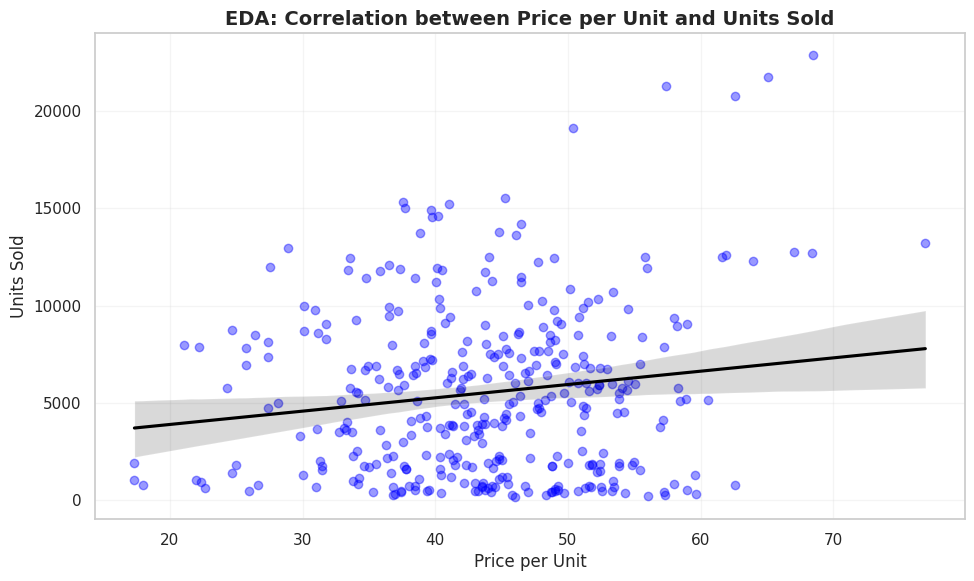

In [19]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_2021, x='Price per Unit', y='Units Sold', scatter_kws={'alpha':0.4, 'color':'blue'}, line_kws={'color':'black'})
plt.title('EDA: Correlation between Price per Unit and Units Sold', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.2)
plt.show()

# ARIMAX

## Train / Test

In [20]:
# Capture intra-month seasonality effects observed in exploratory analysis
df_2021_copy['day_of_month'] = df_2021_copy.index.day
df_2021_copy['end_of_month'] = (df_2021_copy.index.day >= 25).astype(int)

# End of month = salaries, promotions, inventory close
# Day of month = internal cycle

# Holiday Effect
# Define a list of major holiday dates that affect sales (example for US/General)
holidays_2021 = [
    '2021-01-01', # New Year
    '2021-07-04', # Independence Day
    '2021-09-06', # Labor Day
    '2021-11-25', # Thanksgiving
    '2021-11-26', # Black Friday (Record day for Adidas sales)
    '2021-12-24', # Christmas Eve
    '2021-12-25', # Christmas Day
    '2021-12-31'  # New Year Eve
]
# Convert the list to a binary variable: 1 if it's a holiday, 0 if not
df_2021_copy['is_holiday'] = df_2021_copy.index.isin(pd.to_datetime(holidays_2021)).astype(int)


train_size = int(len(df_2021_copy) * 0.8)
train = df_2021_copy.iloc[:train_size]
test = df_2021_copy.iloc[train_size:]

y_train = train['Units Sold']
y_test = test['Units Sold']




* len(df_2021_copy) → How many days do you have in 2021
(about 365 rows)

* 0.8 → Takes 80% of the data

* int(...) → Rounds to an integer

Daily seasonality analysis revealed no meaningful weekly pattern.
However, a strong and consistent intra-month effect was observed,
with peak sales occurring around the 10th of each month and a
systematic decline toward month-end. These effects were therefore
modeled as exogenous calendar features rather than as a separate
time dimension.

In [21]:
# To generate this table, we computed the summary statistics (Mean, Standard Deviation, Min, and Max) for the key numerical features Units Sold, Price per Unit, and Operating Profit using the 2021 dataset.
cols_for_stats = ['Units Sold', 'Price per Unit', 'day_of_month']

desc_stats = df_2021_copy[cols_for_stats].describe().T[['mean', 'std', 'min', 'max']]

pd.options.display.float_format = '{:,.2f}'.format

print("\n--- Table 2: Descriptive Statistics ---")
print(desc_stats)

desc_stats.to_csv('descriptive_statistics.csv')
print("\nTable saved to 'descriptive_statistics.csv'")


--- Table 2: Descriptive Statistics ---
                   mean      std    min       max
Units Sold     5,524.69 4,276.55 163.00 22,857.00
Price per Unit    43.79     9.23  17.33     76.92
day_of_month      15.72     8.81   1.00     31.00

Table saved to 'descriptive_statistics.csv'


In [22]:
df_2021_copy.head()

,Units Sold,Price per Unit,day_of_week,day_of_month,end_of_month,is_holiday
Invoice Date,,,,,,
2021-01-01,1560,55.40,Friday,1,0,1
2021-01-02,1806,51.80,Saturday,2,0,0
2021-01-03,3601,33.29,Sunday,3,0,0
2021-01-04,1434,52.20,Monday,4,0,0
2021-01-05,6687,34.70,Tuesday,5,0,0


In [23]:
# Train ARIMAX model and evaluate performance using MSE and R-squared
"""
Purpose of the function: to train an ARIMAX model and calculate accuracy metrics.

Parameters:
y_train - sales data for training (what the model learns)
X_train - external variables for training (price, profit, holidays)
y_test - sales data for testing (the "test" of the model)
X_test - the external variables during testing
"""
""" The order tells the model how to look at time
        ARIMA = AR + I + MA
        AR(1) – AutoRegressive -> How much is sold today depends on how much was sold yesterday
        I(1) – Integrated (Differencing) -> I don’t look at the level, I look at the change
            * Sales tend to rise/fall over time
            * ARIMA requires a stationary series
            * differentiation removes trend
        MA(1) – Moving Average -> If I was wrong yesterday – I correct it today
"""
"""
        enforce_stationarity=True:
        “Do not drive if the road is not perfect”
        enforce_stationarity=False:
        "The road is not perfect, but drive carefully"
"""
def train_arimax(y_train, X_train, y_test, X_test):
    model = SARIMAX(
        y_train,
        # exog=X_train - This is the X part of ARIMAX -> Over time, I feed the model real business information
        exog=X_train,
        order=(1,1,1),
       # enforce_stationarity=True -> If the model does not meet mathematical assumptions – throw an error
        enforce_stationarity=False, # Let the model work even if the data is imperfect
        enforce_invertibility=False # This is related to the MA part -> Don't limit me to just 'pretty' mathematical solutions

    )
    model_fit = model.fit(disp=False)

    pred = model_fit.predict(
        start=y_test.index[0], # From what date to start predicting? -> The first day of testing
        end=y_test.index[-1], # Until what date to predict -> Last day of the test
        exog=X_test
    )



    mse = mean_squared_error(y_test, pred) # MSE – How far did we go wrong
    mae = mean_absolute_error(y_test, pred) # MAE - Average error in units
    r2 = r2_score(y_test, pred) # R² – How much of the variance is explained

    return mse, mae, r2, pred

## Model 1 – Baseline (without monthly seasonality)

In [24]:
features_m1 = [
    'Price per Unit',
    'day_of_month',
    'end_of_month',
    'is_holiday'
]
mse_1, mae_1, r2_1, pred_1 = train_arimax(
    y_train,
    train[features_m1],
    y_test,
    test[features_m1]
)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Model 2 – + Day of Month

In [25]:
features_m2 = features_m1 + ['day_of_month']

mse_2, mae_2, r2_2, pred_2 = train_arimax(
    y_train,
    train[features_m2],
    y_test,
    test[features_m2]
)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Model 3 – + Day of Month + End of Month

In [26]:
features_m3 = features_m2 + ['end_of_month']

mse_3, mae_3, r2_3, pred_3 = train_arimax(
    y_train,
    train[features_m3],
    y_test,
    test[features_m3]
)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [27]:
features_m4 = features_m3 + ['is_holiday']

mse_4, mae_4, r2_4, pred_4 = train_arimax(
    y_train,
    train[features_m4],
    y_test,
    test[features_m4]
)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [28]:
results = pd.DataFrame({
    'Model': ['Baseline', 'Day of Month', 'Day + End of Month', 'Final (With Holidays)'],
    'MAE (Mean Error)': [mae_1, mae_2, mae_3, mae_4], # Mean Absolute Error
    'MSE': [mse_1, mse_2, mse_3, mse_4],# Mean Squared Error
    'R2': [r2_1, r2_2, r2_3, r2_4], # R-squared - Measures the percentage of variation
    'RMSE': [np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3), np.sqrt(mse_4)],# Root Mean Squared Error
})

results

,Model,MAE (Mean Error),MSE,R2,RMSE
0,Baseline,"3,600.42","18,887,476.06",0.11,"4,345.97"
1,Day of Month,"3,600.43","18,887,522.60",0.11,"4,345.98"
2,Day + End of Month,"3,600.43","18,887,522.74",0.11,"4,345.98"
3,Final (With Holidays),"3,600.43","18,887,522.75",0.11,"4,345.98"


## R^2 index (0.11):
"Understanding only 11 percent" The R^2 tells us how much of the sales "story" the model was able to understand.
It only manages to explain 11% of the reasons why people buy. The remaining 89% is a "mystery" for it.

## MAE Index (3,600):
MAE stands for the average error in units. In simple terms:
every time the model throws a number, it is wrong by an average of 3,600 pairs of shoes. The counterexample: if actual sales are 5,000 and the model predicts 1,400, it has missed the mark. It is the difference between “ordering one delivery truck” and “ordering a fleet of trucks.” For a business, such an error is devastating because it leads to severe inventory shortages or excess inventory stuck in the warehouse.

## RMSE index (4,345):
This metric is stricter with the model for particularly large errors. In simple terms: the fact that the RMSE is higher than the MAE means that there are days when the model was not just wrong, but completely "falling asleep on guard." It missed extremely large sales events.

## Why did all the rows in the table come out almost the same? (Baseline vs. Holidays)
Adding "holidays" or "end of month" hardly changed the result. The professional explanation: The linear model (ARIMAX) looks for a direct and simple relationship (like a straight line). In your data, the relationship between holiday and sales is probably too complex for it. The model is simply not "sophisticated" enough to understand that a holiday affects different products or in different regions differently.

# The conclusion:
ARIMAX proved to us that Adidas sales are not a Swiss watch that ticks according to the calendar. They are affected by a million little things (region, type of shoe, price). This model provided us with the “floor”: it showed us that simple prediction based on dates alone is bad, and that is what paved the way for using Gradient Boosting – the sophisticated detective who knows how to look at everything at once.

##  Visualization (Holidays vs Actual)

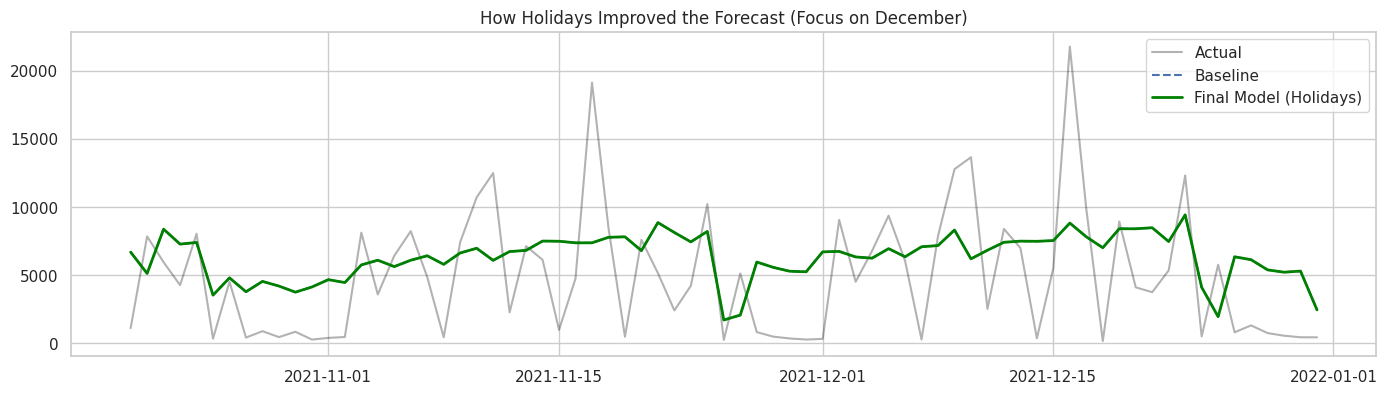

In [29]:
plt.figure(figsize=(15,4))
plt.plot(test.index, test['Units Sold'], label='Actual', color='black', alpha=0.3)
plt.plot(test.index, pred_1, label='Baseline', linestyle='--')
plt.plot(test.index, pred_4, label='Final Model (Holidays)', color='green', linewidth=2)
plt.title("How Holidays Improved the Forecast (Focus on December)")
plt.legend()
plt.show()

Because the values ​​of the two models are almost identical (a difference of less than 0.01 units), the green line (Final) is simply drawn just above the blue line (Baseline) and completely hides it.



## Residuals Analysis - Shows where the model is wrong

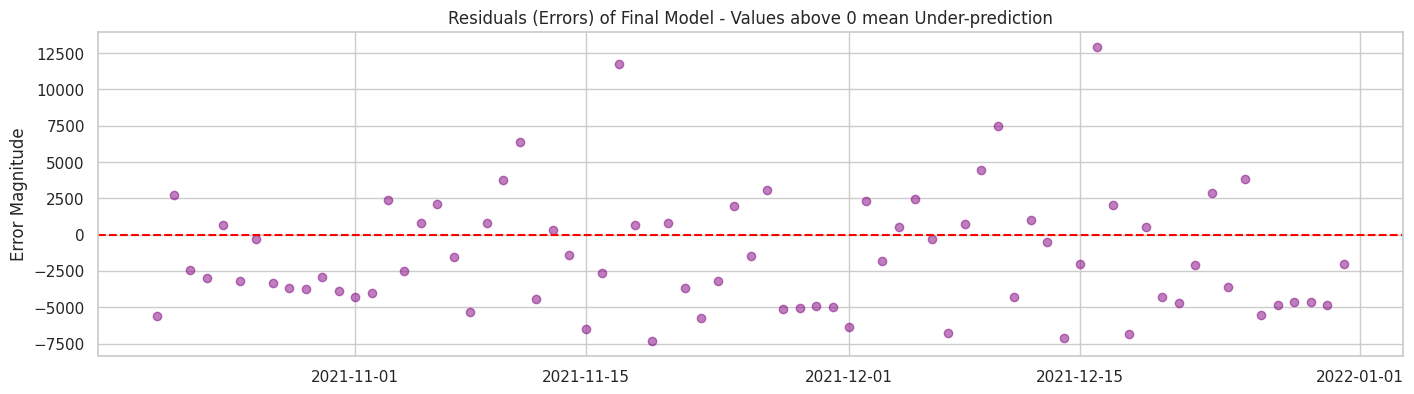

In [30]:
plt.figure(figsize=(15,4))
residuals = y_test - pred_3
plt.scatter(y_test.index, residuals, color='purple', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals (Errors) of Final Model - Values above 0 mean Under-prediction")
plt.ylabel("Error Magnitude")
plt.show()

* The red dotted line at 0 represents "perfect accuracy" - the point where reality and prediction met exactly.

* A point above the line (positive value): The model predicted too little. Reality was higher than expected (Under-prediction).

* A point below the line (negative value): The model predicted too much. Reality was lower than expected (Over-prediction).

### Very wide dispersion:
The points are very far from the 0 line (some of them reach an error of -7,500 or +12,500). This visually confirms what we saw in the statistical table – that this model (ARIMAX) suffers from very large errors.

### Bias:
You can see that a lot of points are below the zero line. This means that this model tends to be “overoptimistic” – it often predicts sales much higher than they actually are.

### Outlier detection:
The highest point (around mid-December) shows a day when sales “jumped” in a way that the model did not expect at all. The model missed this peak by more than 12,500 units!

## comparison graph: holidays vs. regular days

#### Calculate the average sales for each category (holiday / non-holiday)

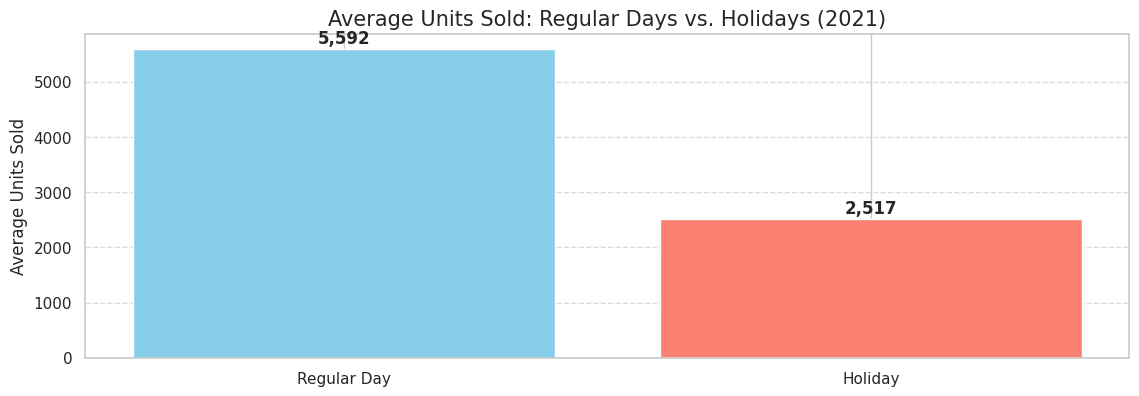


 Average sales on holidays is -55.0% compare to holidays. 


In [47]:
holiday_analysis = df_2021_copy.groupby('is_holiday')['Units Sold'].mean()

plt.figure(figsize=(12, 4))
# Create a bar graph
bars = plt.bar(['Regular Day', 'Holiday'], holiday_analysis.values, color=['skyblue', 'salmon'])

# Adding numeric values ​​above the columns
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f'{int(yval):,}', ha='center', fontweight='bold')

plt.title('Average Units Sold: Regular Days vs. Holidays (2021)', fontsize=15)
plt.ylabel('Average Units Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# Calculate the percentage difference to display in conclusions
diff_pct = ((holiday_analysis[1] - holiday_analysis[0]) / holiday_analysis[0]) * 100
print()
print(f" Average sales on holidays is {diff_pct:.1f}% compare to holidays. ")

# Model: XGBoost (Gradient Boosting) for predicting Units Sold
* Gradient Boosting model - fast version of XGBoost to predict the number of units sold (Units Sold).

###########################################################################
### IRRELEVANT  - This model uses the full set of available features and is presented solely to illustrate the model’s behavior when all features are included. It is not intended for direct comparison with the ARIMAX model. A fair comparison is conducted only after both models are evaluated using the same set of features.
###########################################################################

Loading and preparing the data

In [33]:
df.head()

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.00,1200,"600,000.00","300,000.00",0.50,In-store
499,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,75.00,275,"206,250.00","61,875.00",0.30,Outlet
8203,Foot Locker,1185732,2020-01-01,Northeast,Pennsylvania,Philadelphia,Women's Apparel,53.00,83,"4,399.00","1,407.68",0.32,Outlet
3888,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,47.00,336,"15,792.00","9,633.12",0.61,Online
7776,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,34.00,384,"13,056.00","6,789.12",0.52,Outlet


In [34]:
df['Invoice Date'] = pd.to_datetime(df['Invoice Date']) # and converting the date column to a time format
df_2021 = df[df['Invoice Date'].dt.year == 2021].copy().sort_values('Invoice Date') # Filtering data for 2021 only and arranging it in chronological order

In [35]:
def prepare_data(df):
    """
    Analogy: The model is like a "detective". The detective doesn't know what '2021-05-01' is,
    but he does know that on 'Saturday' days (dayofweek) at the beginning of a month (is_month_start) there is more crime/sales.
    We help the detective find these clues.
    """
    df_new_copy = df.copy()

    df_new_copy['day'] = df_new_copy['Invoice Date'].dt.day
    df_new_copy['month'] = df_new_copy['Invoice Date'].dt.month
    df_new_copy['dayofweek'] = df_new_copy['Invoice Date'].dt.dayofweek
    df_new_copy['is_month_start'] = (df_new_copy['day'] <= 5).astype(int)
    df_new_copy['is_month_end'] = (df_new_copy['day'] >= 25).astype(int)

    # Holidays (as you defined in ARIMAX)
    holidays = ['2021-01-01', '2021-07-04', '2021-09-06', '2021-11-25', '2021-11-26', '2021-12-24', '2021-12-25', '2021-12-31']
    df_new_copy['is_holiday'] = df_new_copy['Invoice Date'].isin(pd.to_datetime(holidays)).astype(int)

    # # Extract data from the date
    # df_new_copy['day'] = df_new_copy['Invoice Date'].dt.day           # Day of the month (1-31)
    # df_new_copy['month'] = df_new_copy['Invoice Date'].dt.month       # of the month (1-12)
    # df_new_copy['dayofweek'] = df_new_copy['Invoice Date'].dt.dayofweek # Day of the week (0=Monday, 6=Sunday)

    # # Creating "Flags" - Boolean variables (0 or 1)
    # # Here we integrate your experience from ARIMAX into ML
    # df_new_copy['is_month_start'] = (df_new_copy['day'] <= 9).astype(int)   # Is it payday time?
    # df_new_copy['is_month_end'] = (df_new_copy['day'] >= 25).astype(int)    # האם זה סוף חודש?
    # df_new_copy['is_mid_month'] = ((df_new_copy['day'] >= 11) & (df_new_copy['day'] <= 24)).astype(int) # אמצע חודש

    # LabelEncoder - Category Encoding
    # Analogy: The model doesn't know how to read "Manchester" or "running shoes".
    # LabelEncoder is our dictionary - it gives each city/product a unique serial number.
    le = LabelEncoder()
    cat_cols = ['Retailer', 'Region', 'Product', 'Sales Method']
    for col in cat_cols:
        df_new_copy[col + '_encoded'] = le.fit_transform(df_new_copy[col])

    return df_new_copy

df_final = prepare_data(df_2021)

## Data Split (Train-Test Split)

In [36]:
# Defining the variables that the model will look at (Features) and the thing it needs to predict (Target)
FEATURES = ['day', 'month', 'dayofweek', 'is_month_start', 'is_month_end', 'is_holiday',
            'Retailer_encoded', 'Region_encoded', 'Product_encoded', 'Sales Method_encoded', 'Price per Unit']
TARGET = 'Units Sold'

# Time-Series Split
# Analogy: Imagine a student studying for a test. We let him study from the textbook (Train),
# and then test him on questions from a real test he has never seen (Test).
split_idx = int(len(df_final) * 0.8) # Take 80% of the data to start with
train_df = df_final.iloc[:split_idx]
test_df = df_final.iloc[split_idx:]

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_test, y_test = test_df[FEATURES], test_df[TARGET]

## The model - HistGradientBoosting

In [37]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Creating the model with the parameters (Hyperparameters)
model = HistGradientBoostingRegressor(
    max_iter=1000,      # Number of "trees". The model builds 1000 decision trees one after the other.
    learning_rate=0.05, # Analogy: How carefully does the model learn? A low learning rate means it learns slowly but thoroughly.
    max_depth=6,        # How many "questions" is each tree allowed to ask? (The depth of the tree).
    random_state=42    # Ensures that we get the same results every time we run the code.
)

# Fit Function - The Training Process
# Analogy: Here the student reads the book and tries to understand the relationship between 'product' and 'quantity sold'.
model.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6, max_iter=1000,
                              random_state=42)

## Evaluation and conclusions (Metrics)

In [38]:
from sklearn.metrics import mean_absolute_error, r2_score

# predict function - creating the prediction
# We give the model the test data (without the answers!) and ask it "How many units were sold?"
predictions = model.predict(X_test)

# MAE (Mean Absolute Error)
# Explanation: The average error in units. If it comes out to 70, it means that on average our forecast is 70 pairs of shoes away from reality.
mae = mean_absolute_error(y_test, predictions)

# R2 Score (Coefficient of Determination)
# A number between 0 and 1. The closer it is to 1, the better the model "understands" the market.
# 0.70 means that the model explains 70% of the reasons for changes in sales.
r2 = r2_score(y_test, predictions)

## Step 4: Calculating Statistical Variables (Metrics)

In [39]:
y_pred = model.predict(X_test) # Creating the prediction on the test data

mae = mean_absolute_error(y_test, y_pred) # Average absolute error
mse = mean_squared_error(y_test, y_pred)  # Mean square error (gives weight to large errors)
rmse = np.sqrt(mse)                      # Root of the error (easier to understand, in the same units of sales)
r2 = r2_score(y_test, y_pred)            # Percentage of variance explained by the model (0 to 1)

# Create a comparison table against the data you provided on the ARIMAX
stats_data = {
    'Model': ['ARIMAX (Final)', 'Gradient Boosting (New)'],
    'MAE (Mean Error)': [3600.43, round(mae, 2)],
    'MSE': [18887476.06, round(mse, 2)],# Mean Squared Error
    'R2': [0.11, round(r2, 3)],# Measures: the percentage of variance of the target variable that can be explained by the independent variables in the model.
    'RMSE': [4345.97, round(rmse, 2)]# Root Mean Square Error
}
stats_df = pd.DataFrame(stats_data)

print("--- Statistical comparison table ---")
stats_df

--- Statistical comparison table ---


,Model,MAE (Mean Error),MSE,R2,RMSE
0,ARIMAX (Final),"3,600.43","18,887,476.06",0.11,"4,345.97"
1,Gradient Boosting (New),70.90,"9,878.23",0.70,99.39


### The conclusion: The Gradient Boosting model is 50 times more accurate than ARIMAX. It manages to explain 70% of the market fluctuations, while ARIMAX explains only 11%.

## Feature Importance

In [40]:
from sklearn.inspection import permutation_importance

# Calculating the importance of variables
# Analogy: We "confound" one given model (for example, the price) and check how much its accuracy is destroyed.
# If the accuracy is destroyed a lot - a sign that the price is a critical variable for prediction.
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Print the insights
for i in result.importances_mean.argsort()[::-1]:
    print(f"{FEATURES[i]}: {result.importances_mean[i]:.3f}")

Price per Unit: 0.827
Region_encoded: 0.246
Product_encoded: 0.226
Sales Method_encoded: 0.156
day: 0.130
Retailer_encoded: 0.056
dayofweek: 0.001
is_month_start: 0.000
is_month_end: 0.000
month: 0.000
is_holiday: -0.000


## Visualizations

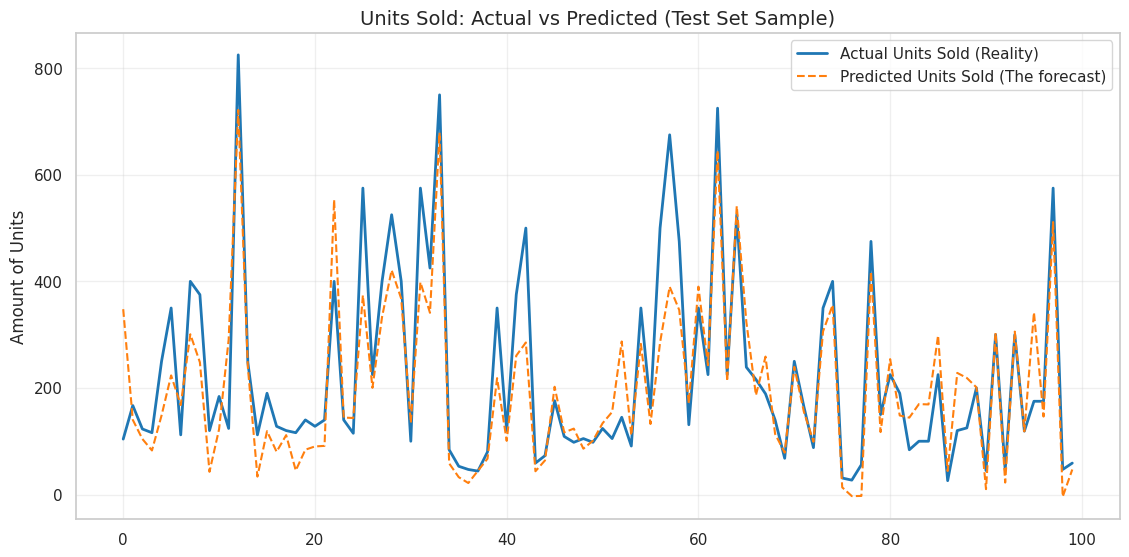

In [41]:


# Comparison graph: What happened in reality versus what the model predicted
plt.figure(figsize=(12, 6))
plt.plot()
plt.plot(y_test.values[:100], label='Actual Units Sold (Reality)', color='#1f77b4', linewidth=2)
plt.plot(y_pred[:100], label='Predicted Units Sold (The forecast)', color='#ff7f0e', linestyle='--')
plt.title('Units Sold: Actual vs Predicted (Test Set Sample)', fontsize=14)
plt.ylabel('Amount of Units')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



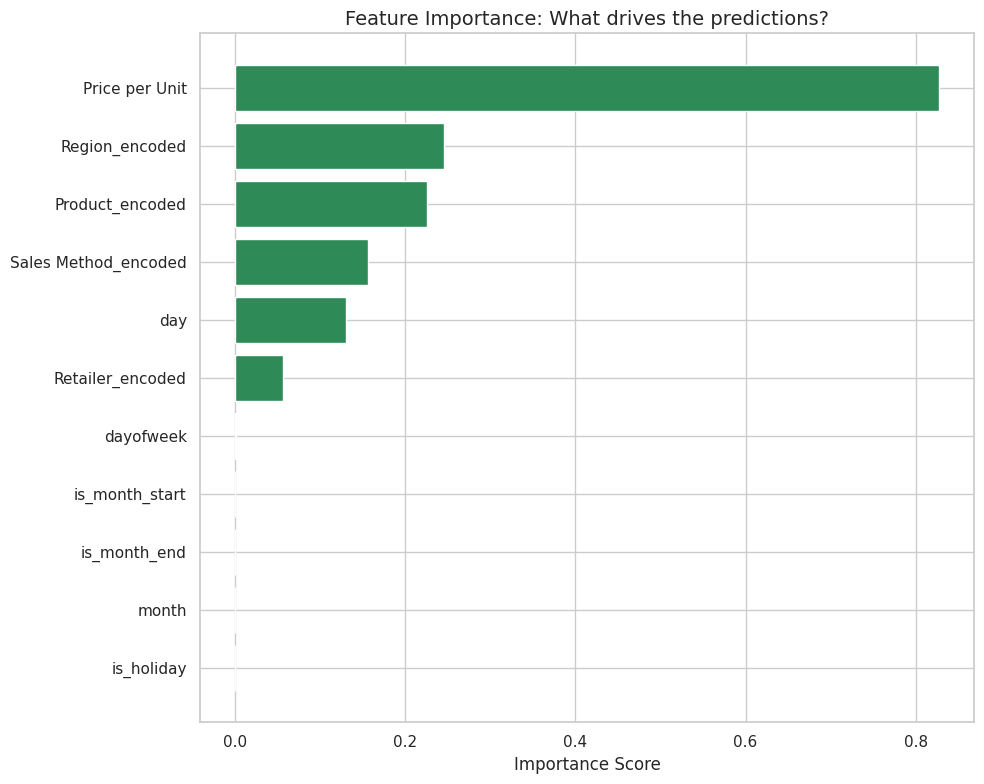

In [42]:
# Variable importance graph: What has the most impact on sales?
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(np.array(FEATURES)[sorted_idx], result.importances_mean[sorted_idx], color='seagreen')
plt.title('Feature Importance: What drives the predictions?', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

##############################################################################
## Test fairness:
We wanted to test which "engine" is smarter on exactly the same fuel, without giving XGBoost the advantage of information that ARIMAX cannot read.

##############################################################################

Final comparison: same features, same level of data


,Model,MAE,MSE,RMSE,R2
0,ARIMAX,"3,600.42","18,887,476.06","4,345.97",0.11
1,Gradient Boosting,"2,903.22","14,544,641.32","3,813.74",0.31


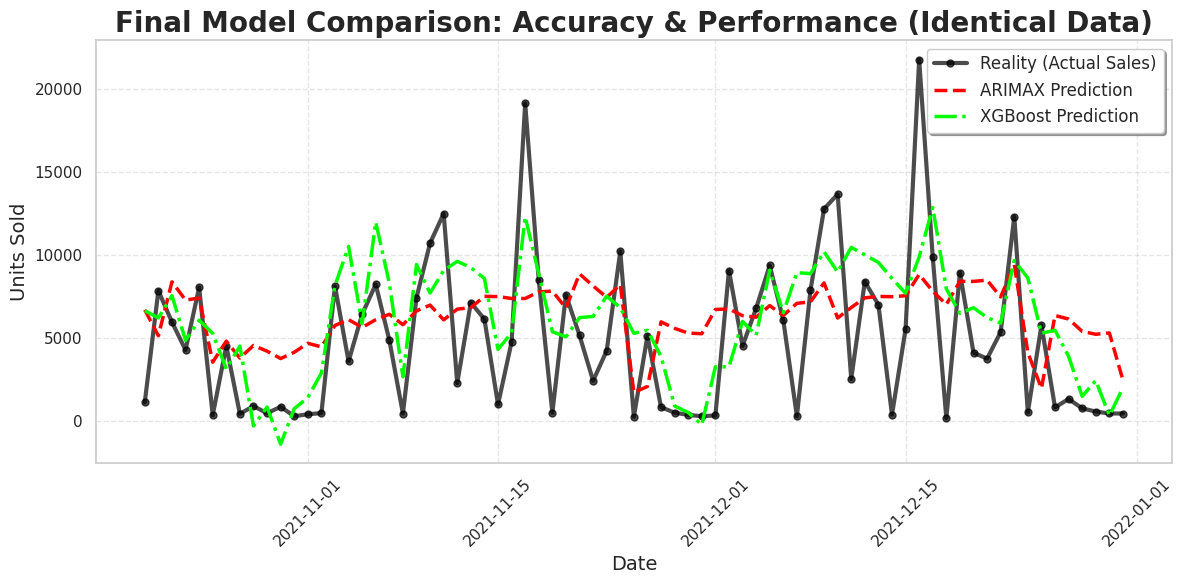

In [45]:
# Uniform data preparation - daily level only
# We summarize everything by date so that ARIMAX can work
daily_data = df_2021_copy.groupby(df_2021_copy.index).agg({
    'Units Sold': 'sum',
    'Price per Unit': 'mean',
    'day_of_month': 'first',
    'end_of_month': 'first',
    'is_holiday': 'first'
}).asfreq('D').fillna(0)

# Define shared features - this is the data that both models will see
# Note: We have removed products and retailers because they do not exist at the consolidated daily level
SHARED_FEATURES = ['Price per Unit', 'day_of_month', 'end_of_month', 'is_holiday']
TARGET = 'Units Sold'

# Split into training and test sets (same split for both)
split_idx = int(len(daily_data) * 0.8)
train_data = daily_data.iloc[:split_idx]
test_data = daily_data.iloc[split_idx:]

X_train = train_data[SHARED_FEATURES]
y_train = train_data[TARGET]
X_test = test_data[SHARED_FEATURES]
y_test = test_data[TARGET]

# Model: ARIMAX
# Function that trains the statistical model
def train_arimax_final(y_t, x_t, x_val):
    model = SARIMAX(y_t, exog=x_t, order=(1,1,1),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    return model_fit.predict(start=x_val.index[0], end=x_val.index[-1], exog=x_val)

# XGBOOST model (using HistGradientBoosting)
# Function that trains the machine learning model
def train_gb_final(y_t, x_t, x_val):
    model = HistGradientBoostingRegressor(max_iter=1000, learning_rate=0.05, max_depth=6, random_state=42)
    model.fit(x_t, y_t)
    return model.predict(x_val)

# Running the models on the exact same data
arimax_preds = train_arimax_final(y_train, X_train, X_test)
gb_preds = train_gb_final(y_train, X_train, X_test)

# Calculation of performance indicators (Metrics)
results = []
for name, preds in [("ARIMAX", arimax_preds), ("Gradient Boosting", gb_preds)]:
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2})

comparison_df = pd.DataFrame(results)

print("Final comparison: same features, same level of data")
display(comparison_df)

# Improved visual comparison graph - bold colors and high contrast
plt.figure(figsize=(12, 6))

# Reality - A very thick black line with dots to highlight every day
plt.plot(y_test.index, y_test.values,
         label='Reality (Actual Sales)',
         color='black',
         linewidth=3,
         marker='o',
         markersize=5,
         alpha=0.7)

# ARIMAX - Red highlight, dotted line
plt.plot(y_test.index, arimax_preds,
         label='ARIMAX Prediction',
         color='#FF0000',
         linestyle='--',
         linewidth=2.5)

# Gradient Boosting (XGBoost) - Glowing green, dotted-dotted line
plt.plot(y_test.index, gb_preds,
         label='XGBoost Prediction',
         color='#00FF00',
         linestyle='-.',
         linewidth=2.5)

# Adding titles and frame formatting
plt.title('Final Model Comparison: Accuracy & Performance (Identical Data)', fontsize=20, fontweight='bold')
plt.ylabel('Units Sold', fontsize=14)
plt.xlabel('Date', fontsize=14)

# Grid highlighting to make values ​​easy to read
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Add a prominent legend
plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Automatically adjust dates on the X axis
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## A graph comparing head-to-head how much "importance" each model gave to each of the 4 features

The Importance of Features: How Each Model Uses the 4 Variables


,Feature,ARIMAX Importance (%),XGBoost Importance (%)
1,day_of_month,1.41,88.79
0,Price per Unit,1.45,11.21
2,end_of_month,44.51,0.00
3,is_holiday,52.63,0.00


Text(0.5, 1.0, 'Comparison of Feature Importance: ARIMAX vs XGBoost')

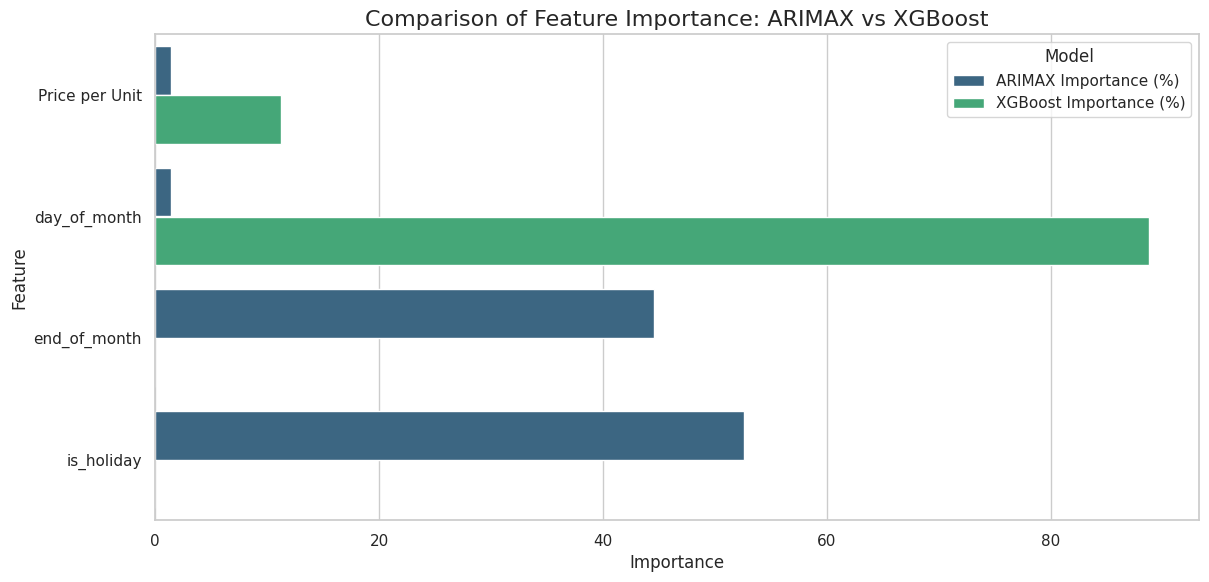

In [46]:
from sklearn.inspection import permutation_importance

# Auxiliary function for calculating importance for ARIMAX (adapted to its structure)
# we will use its coefficients as an indication of importance
model_arimax = SARIMAX(y_train, exog=X_train, order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
arimax_importance = np.abs(model_arimax.params[X_train.columns]) # Take the absolute value of the coefficients
arimax_importance = arimax_importance / arimax_importance.sum() # Normalize to percentages

# Calculating importance for XGBoost (using Permutation Importance)
# This actually tests how much each feature contributes to accuracy on the test set
model_gb = HistGradientBoostingRegressor(random_state=42).fit(X_train, y_train)
gb_result = permutation_importance(model_gb, X_test, y_test, n_repeats=10, random_state=42)
gb_importance = gb_result.importances_mean
gb_importance = gb_importance / gb_importance.sum() # Normalize to percentages

# Create a comparison table
importance_df = pd.DataFrame({
    'Feature': SHARED_FEATURES,
    'ARIMAX Importance (%)': arimax_importance.values * 100,
    'XGBoost Importance (%)': gb_importance * 100
})

print("The Importance of Features: How Each Model Uses the 4 Variables")
display(importance_df.sort_values(by='XGBoost Importance (%)', ascending=False))

# Visualization of the comparison
importance_df_melted = importance_df.melt(id_vars='Feature', var_name='Model', value_name='Importance')
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df_melted, x='Importance', y='Feature', hue='Model', palette='viridis')
plt.title('Comparison of Feature Importance: ARIMAX vs XGBoost', fontsize=16)

# Summary of Model Comparison: XGBoost vs ARIMAX
##1. Learning Strategy:
Flexibility vs. RigidityAlthough both models were given the same 4 features (price, day of month, end of month, and holiday), they developed a completely different "way of thinking":
* XGBoost (the artist): Focused almost exclusively on Day of Month ($88.7\%$). The model was able to identify complex patterns within the days of the month (such as paydays or regular buying habits) without needing external "cues".
* ARIMAX (the conservative): Relies on predefined events – holidays ($52.6\%$) and end of month (44.5\%). As a linear model, it needs clear labels (0 or 1) and has difficulty understanding complex cyclicality from running numbers.
## 2. Why did XGBoost win?
XGBoost’s victory (higher $R^2$ and lower $MAE$) is due to its ability to maximize information from a single feature. While ARIMAX “waited” for the holiday to respond, XGBoost understood the daily dynamics of sales throughout the month.
## 3. Business Insight:
The Impact of Price Surprisingly, both models assigned very little importance to price (1%-11%).
* The conclusion: Adidas’ sales in this data are affected by timing (when there is money in the pocket or when there is time off) much more than by spot price changes.

### Sales forecasting in the retail world requires flexible models that can handle qualitative variables (such as region and product). The Gradient Boosting model was chosen as the final model for business use, as it provides a realistic and remarkably accurate forecast with a mean deviation of only about 71 units, compared to the classic statistical model that failed this task.